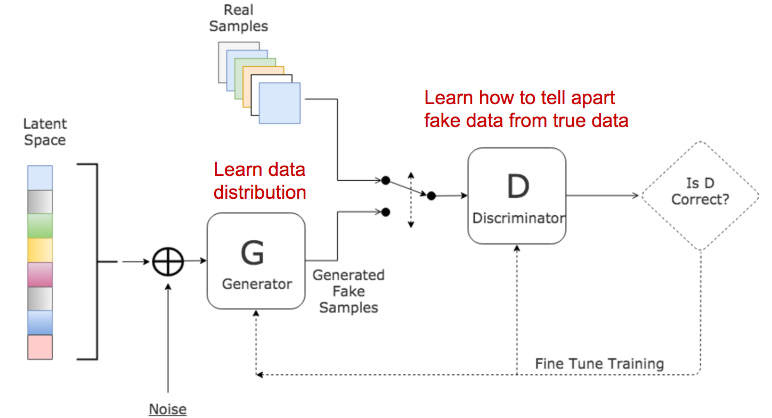

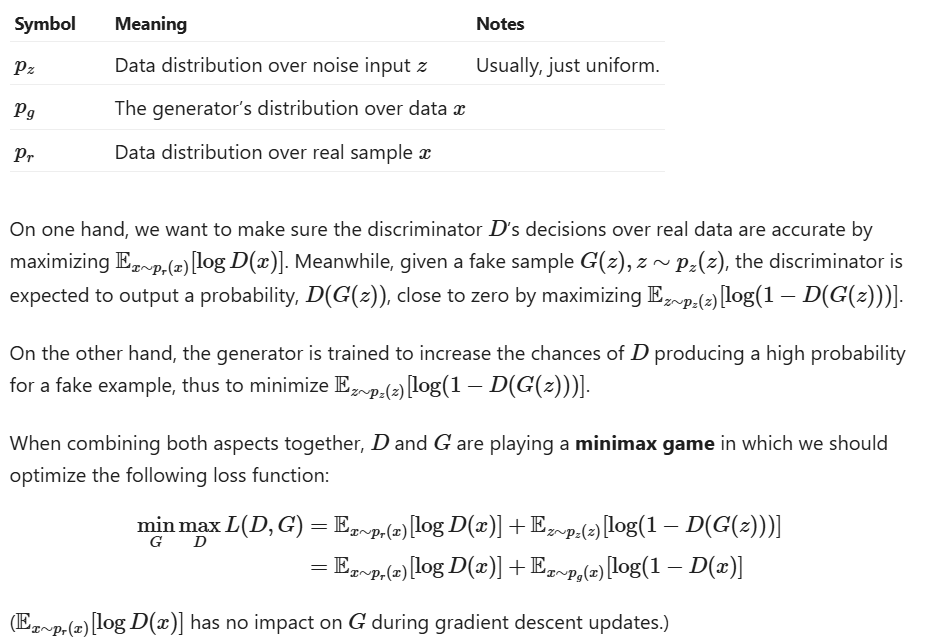

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#parameters
image_size = 64   # DCGAN likes 64
batch_size = 128
latent_dim = 100

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(), # converts to float AND divides by 255 (normalize).
    transforms.Normalize(mean=[0.5], std=[0.5])  # scale to [-1, 1]
])

# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root="C:\\Abhishek_Data\\Datasets", train=True, transform=transform)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = torchvision.datasets.FashionMNIST(root='C:\\Abhishek_Data\\Datasets', train=False, download=True, transform=transform)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

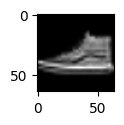

In [5]:
# get images and labels from loader
numbers, labels = next(iter(train_loader))

# visualize one image
images = numbers.numpy()
# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (1,1)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In Standard GAN (Binary Cross Entropy Based):

The Discriminator (D) is trained to:
  - maximize log(D(real)) → classify real images as real (label=1)
  - maximize log(1 - D(fake)) → classify fake images as fake (label=0)

  These two objectives are combined as:
  - D_loss = BCE(D(real_images), real_labels) + BCE(D(fake_images), fake_labels)

  - D(real_images) should be close to 1
  - D(fake_images) should be close to 0
  - Hence, D needs both losses, one for real samples and one for fake.

For Generator:
Generator wants to fool the Discriminator, so it tries to make D(G(z)) close to 1

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, latent_dim, output_size):
        super(Discriminator, self).__init__()

        self.disciminator = nn.Sequential(
            nn.Conv2d(1, image_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(),

            nn.Conv2d(image_size, image_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.LeakyReLU(),

            nn.Conv2d(image_size*2, image_size*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.LeakyReLU(),

            nn.Conv2d(image_size*4, image_size*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            nn.Linear(512*4*4, output_size),
            nn.Sigmoid()   # maps real numbers to the (0,1), interpreted as the confidence that the input is real
        )
        
    def forward(self, x):
        # flatten image
        out = self.disciminator(x)

        return out


In [15]:
class Generator(nn.Module):

    def __init__(self, latent_dim, image_size):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, image_size*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(),

            nn.ConvTranspose2d(image_size*8, image_size*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(),

            nn.ConvTranspose2d(image_size*4, image_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(),

            nn.ConvTranspose2d(image_size*2, image_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(),
            
            nn.ConvTranspose2d(image_size, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.generator(x)
        return out

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
# build models and move to device
D = Discriminator(latent_dim, 1)
G = Generator(latent_dim, image_size)

# weight init
D.apply(weights_init)
G.apply(weights_init)

# Send models to device
D = D.to(device)
G = G.to(device)

In [18]:
# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = optim.Adam(G.parameters(), lr=0.0001)

In [19]:
# For generating latent noise
def generate_noise(batch_size, latent_size):
    z = torch.randn(batch_size, latent_size, device=device)
    z = z.view(batch_size, latent_dim, 1, 1)
    return z

Label smoothing: When the Discriminator gets perfect (D(x) = 1, D(G(z)) = 0), gradients for the Generator vanish. Smoothing gives some room for G to improve
  - Loss = -[ y * log(p) + (1 - y) * log(1 - p) ] →   BCE Loss
  - Loss = -log(p)                                → pushes p to 1 (without smoothing y=1)
  - Loss = -[0.9 * log(p) + 0.1 * log(1 - p)]     → allows some error (with smoothing y=0.9)

Epoch [1/150], d_loss: 0.3649, g_loss: 4.3465
Epoch [2/150], d_loss: 0.3605, g_loss: 4.6091
Epoch [3/150], d_loss: 0.4921, g_loss: 4.6691
Epoch [4/150], d_loss: 0.3734, g_loss: 5.6244
Epoch [5/150], d_loss: 0.3762, g_loss: 4.2435
Epoch [6/150], d_loss: 0.4102, g_loss: 4.3478
Epoch [7/150], d_loss: 0.3949, g_loss: 3.7321
Epoch [8/150], d_loss: 0.3569, g_loss: 6.6459
Epoch [9/150], d_loss: 0.3914, g_loss: 4.1490
Epoch [10/150], d_loss: 0.3746, g_loss: 4.3414
Epoch [11/150], d_loss: 0.4465, g_loss: 2.7259
Epoch [12/150], d_loss: 0.3920, g_loss: 3.6064
Epoch [13/150], d_loss: 0.3595, g_loss: 3.6612
Epoch [14/150], d_loss: 0.4201, g_loss: 2.4988
Epoch [15/150], d_loss: 0.4007, g_loss: 3.2752
Epoch [16/150], d_loss: 0.3789, g_loss: 4.0193
Epoch [17/150], d_loss: 0.3771, g_loss: 4.0372
Epoch [18/150], d_loss: 0.3590, g_loss: 4.6694
Epoch [19/150], d_loss: 0.3801, g_loss: 4.8041
Epoch [20/150], d_loss: 0.3846, g_loss: 4.2314
Epoch [21/150], d_loss: 0.4421, g_loss: 3.6055
Epoch [22/150], d_loss

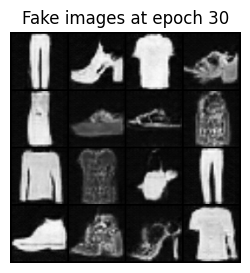

Epoch [31/150], d_loss: 0.4492, g_loss: 4.5884
Epoch [32/150], d_loss: 0.3919, g_loss: 4.5264
Epoch [33/150], d_loss: 0.4276, g_loss: 3.4439
Epoch [34/150], d_loss: 0.3677, g_loss: 4.2396
Epoch [35/150], d_loss: 0.3785, g_loss: 4.3492
Epoch [36/150], d_loss: 0.3690, g_loss: 5.6364
Epoch [37/150], d_loss: 0.3610, g_loss: 4.7585
Epoch [38/150], d_loss: 0.3796, g_loss: 4.2108
Epoch [39/150], d_loss: 0.3570, g_loss: 4.8815
Epoch [40/150], d_loss: 0.4026, g_loss: 3.8936
Epoch [41/150], d_loss: 0.3569, g_loss: 5.3144
Epoch [42/150], d_loss: 0.3577, g_loss: 4.7614
Epoch [43/150], d_loss: 0.3889, g_loss: 5.2280
Epoch [44/150], d_loss: 0.3542, g_loss: 5.3347
Epoch [45/150], d_loss: 0.3699, g_loss: 4.8908
Epoch [46/150], d_loss: 0.3436, g_loss: 5.0049
Epoch [47/150], d_loss: 0.3864, g_loss: 6.3663
Epoch [48/150], d_loss: 0.3695, g_loss: 4.4510
Epoch [49/150], d_loss: 0.3951, g_loss: 3.2685
Epoch [50/150], d_loss: 0.3725, g_loss: 4.2045
Epoch [51/150], d_loss: 0.3850, g_loss: 3.6989
Epoch [52/150

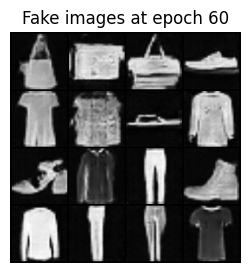

Epoch [61/150], d_loss: 0.3717, g_loss: 5.0786
Epoch [62/150], d_loss: 0.3611, g_loss: 4.5740
Epoch [63/150], d_loss: 0.3672, g_loss: 4.9807
Epoch [64/150], d_loss: 0.3523, g_loss: 4.8898
Epoch [65/150], d_loss: 0.3572, g_loss: 5.4144
Epoch [66/150], d_loss: 0.3566, g_loss: 6.0902
Epoch [67/150], d_loss: 0.4686, g_loss: 4.4115
Epoch [68/150], d_loss: 0.3416, g_loss: 5.0264
Epoch [69/150], d_loss: 0.3493, g_loss: 4.2938
Epoch [70/150], d_loss: 0.4104, g_loss: 5.1708
Epoch [71/150], d_loss: 0.3487, g_loss: 4.8983
Epoch [72/150], d_loss: 0.3827, g_loss: 4.8334
Epoch [73/150], d_loss: 0.3880, g_loss: 5.1416
Epoch [74/150], d_loss: 0.3502, g_loss: 4.6528
Epoch [75/150], d_loss: 0.4311, g_loss: 4.0869
Epoch [76/150], d_loss: 0.3615, g_loss: 4.9660
Epoch [77/150], d_loss: 0.4588, g_loss: 5.3488
Epoch [78/150], d_loss: 0.4289, g_loss: 4.4425
Epoch [79/150], d_loss: 0.3590, g_loss: 4.8466
Epoch [80/150], d_loss: 0.3633, g_loss: 4.2815
Epoch [81/150], d_loss: 0.3495, g_loss: 4.4603
Epoch [82/150

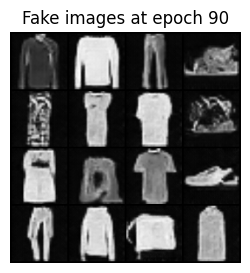

Epoch [91/150], d_loss: 0.3551, g_loss: 4.8683
Epoch [92/150], d_loss: 0.3474, g_loss: 3.1215
Epoch [93/150], d_loss: 0.3441, g_loss: 5.7164
Epoch [94/150], d_loss: 0.3423, g_loss: 5.9215
Epoch [95/150], d_loss: 0.3765, g_loss: 3.7380
Epoch [96/150], d_loss: 0.3595, g_loss: 6.0971
Epoch [97/150], d_loss: 0.3507, g_loss: 4.1065
Epoch [98/150], d_loss: 0.3615, g_loss: 4.5060
Epoch [99/150], d_loss: 0.3469, g_loss: 6.1469
Epoch [100/150], d_loss: 0.3981, g_loss: 6.1533
Epoch [101/150], d_loss: 0.3418, g_loss: 6.4318
Epoch [102/150], d_loss: 0.3407, g_loss: 4.6691
Epoch [103/150], d_loss: 0.3745, g_loss: 4.6404
Epoch [104/150], d_loss: 0.4194, g_loss: 3.7239
Epoch [105/150], d_loss: 0.4321, g_loss: 3.9736
Epoch [106/150], d_loss: 0.3868, g_loss: 5.0948
Epoch [107/150], d_loss: 0.5116, g_loss: 2.7391
Epoch [108/150], d_loss: 0.4152, g_loss: 3.5296
Epoch [109/150], d_loss: 0.4258, g_loss: 6.6049
Epoch [110/150], d_loss: 0.3599, g_loss: 5.4300
Epoch [111/150], d_loss: 0.3501, g_loss: 5.5558
E

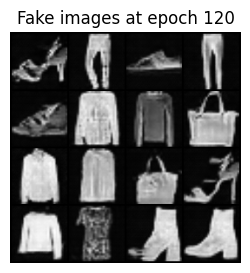

Epoch [121/150], d_loss: 0.3769, g_loss: 5.1678
Epoch [122/150], d_loss: 0.3393, g_loss: 4.6077
Epoch [123/150], d_loss: 0.3404, g_loss: 5.4199
Epoch [124/150], d_loss: 0.4362, g_loss: 4.4651
Epoch [125/150], d_loss: 0.3789, g_loss: 4.9459
Epoch [126/150], d_loss: 0.3414, g_loss: 4.7931
Epoch [127/150], d_loss: 0.3464, g_loss: 6.0424
Epoch [128/150], d_loss: 0.4369, g_loss: 3.1633
Epoch [129/150], d_loss: 0.3451, g_loss: 5.6556
Epoch [130/150], d_loss: 0.3431, g_loss: 4.9944
Epoch [131/150], d_loss: 0.3364, g_loss: 6.0949
Epoch [132/150], d_loss: 0.3390, g_loss: 5.6238
Epoch [133/150], d_loss: 0.3509, g_loss: 5.4701
Epoch [134/150], d_loss: 0.3432, g_loss: 5.3789
Epoch [135/150], d_loss: 0.3475, g_loss: 5.6285
Epoch [136/150], d_loss: 0.3425, g_loss: 4.8180
Epoch [137/150], d_loss: 0.5071, g_loss: 2.7507
Epoch [138/150], d_loss: 0.3407, g_loss: 6.1844
Epoch [139/150], d_loss: 0.3656, g_loss: 5.6949
Epoch [140/150], d_loss: 0.3352, g_loss: 5.9379
Epoch [141/150], d_loss: 0.3497, g_loss:

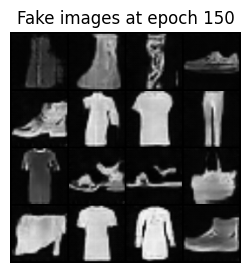

In [ ]:
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        real_images = real_images.view(-1, 1, image_size, image_size).to(device)
        batch_size_curr = real_images.size(0)

        # Labels for real and fake images
        #real_labels = torch.ones(batch_size_curr, 1).to(device)
        real_labels = torch.full((batch_size_curr, 1), 0.9).to(device)  # label smoothing Helps prevent Discriminator overconfidences
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # Train Discriminator

        # Calculate how well 'D' classifies real as real
        outputs = D(real_images)  # probabilities in the range (0, 1), not just 1 or 0
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Evaluate how well 'D' classifies fake as fake
        noise = generate_noise(batch_size_curr, latent_dim)
        fake_images = G(noise) # Generate fake images
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake

        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        # Compute how well G fools D into classifying fakes as real (i.e., real_labels used)
        noise = generate_noise(batch_size_curr, latent_dim)
        fake_images = G(noise)  # Generate new fake images
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)  # We want the fake images to be classified as real

        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Generate and show fake images every 10 epochs
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            fake_images = fake_images.reshape(-1, 1, image_size, image_size)
            fake_images = fake_images[:16]
            grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
            plt.figure(figsize=(3,3))
            plt.imshow(grid.permute(1,2,0).cpu())
            plt.axis('off')
            plt.title(f'Fake images at epoch {epoch+1}')
            plt.show()

Problems with GANS:

Mode Collapse
  - Generator finds a few outputs that fool the discriminator, and keeps repeating them instead of exploring new modes of the data
  - Use MiniBatch discrimination, WGAN, Feature matching

Non-convergence/Oscillation
  - Training fails to converge, never reach a stable equilibrium 
  - Loss values fluctuates with no improvement in quality
  - Use WGAN-GP, label smoothing and Batch Normalization

Vanishing Gradients
  - Generator stops learning because Discriminator becomes too strong causing gradients to vanish. When D is perfect, log(1-D(G(x))) -> 0
  - Generator loss is stuck, output doesn't improve
  - Use WGAN, non saturating loss for G: -log(D(G(z))) insted of log(1-D(G(z)))

Training instability
  - small changes in hyp param lead to divergent behaviour
  - model suddenly starts producing junk after working well, loss explodes
  - Use weight init, WGAN=GP

Discriminator overfitting
  - D memorizes real data and stops generalizing
  - D quickly reaches 100 % accuracy and G fails to improve
  - Use Data augmentation, early stopping, reduce D's capacity

Evaluation metrics
  - Can't tell when to stop training, hard to quantify how good data is
  - Can't tell when to stop training
  - Use FID, Inception score etc


